# Sensitivity of Cylinder drag to radius

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import ibmos as ib

# Case setup

In [3]:
Re = 40.0
R = 0.5
ϵ = 1e-8

## Grid and solver initialization

In [4]:
s1 = ib.stretching(192, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
s2 = ib.stretching(96, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
x = np.concatenate([-s2[::-1], s1[1:]])

s = ib.stretching(128, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
y = np.concatenate([-s[::-1], s[1:]])

solver = ib.Solver(x, y, iRe=1/Re, Co=0.5)
solver.set_solids(ib.shapes.cylinder("cylinder", 0, 0, R, solver.dxmin))
#solver.plot_domain(figsize=(6, 5));

## Boundary conditions

In [5]:
uBC, vBC = solver.zero_boundary_conditions()
for k in range(4):
    uBC[k][:] = 1

sBC = ((np.zeros(solver.solids[0].l), np.zeros(solver.solids[0].l)), )

## Steady simulation

In [6]:
q = solver.zero(); q[:solver.fluid.u.size] = 1.0
q, info = solver.steady_state(q, uBC, vBC, sBC, outflowEast=False, verbose=True)

   k   residual_x   residual_f  cylinder_fx  cylinder_fy 
   1  3.98740e-01  1.95671e+00  3.09308e+00 -5.87204e-15 
   2  2.59878e-01  2.95697e-02  1.61336e+00 -8.27463e-16 
   3  1.31933e-02  4.38965e-03  1.58140e+00  2.66280e-16 
   4  5.48359e-04  5.08697e-04  1.58075e+00  3.38271e-16 
   5  1.37778e-06  3.17922e-06  1.58075e+00  1.34441e-16 
   6  1.42695e-11  5.16216e-11  1.58075e+00  2.15106e-16 


In [7]:
Jq = solver.zero()
Jq[solver.pEnd:solver.pEnd+solver.solids[0].l] = 2
print("Cd =", Jq@q)

Cd = 1.5807452876361379


# Sensitivity

## ... to change in cylinder radius

In [8]:
solver_ϵ = ib.Solver(x, y, iRe=1/Re, Co=0.5)
solver_ϵ.set_solids(ib.shapes.cylinder("cylinder", 0, 0, R+ϵ, solver.dxmin))

In [9]:
def residual(s, x, uBC, vBC, *sBC):
    JnoAdv = s.jacobian(uBC, vBC)
    
    b = s.boundary_condition_terms(uBC, vBC, *sBC)
    u0, v0 = s.reshape(*s.unpack(x))[:2]
    b[:s.pStart] -= np.r_[s.fluid.advection(u0, v0, uBC, vBC)] 
    return JnoAdv @ x - b

## Using the steady_state solver ...

In [10]:
qϵ, infoϵ = solver_ϵ.steady_state(q, uBC, vBC, sBC, outflowEast=False, verbose=True)
qu_steady_state = (qϵ-q)/ϵ

   k   residual_x   residual_f  cylinder_fx  cylinder_fy 
   1  3.43269e-08  5.75532e-08  1.58075e+00 -7.63278e-17 
   2  1.04398e-15  2.42370e-15  1.58075e+00 -5.03070e-17 


# Using 1st-order sensitivities

In [11]:
Rq = solver.jacobian(uBC, vBC, *solver.reshape(*solver.unpack(q))[:2])
Ru = (residual(solver_ϵ, q, uBC, vBC, *sBC))/ϵ

## Using forward sensitivities

In [12]:
qu_forward = -solver.solver(Rq)[0](Ru)

## Using backward sensitivities

In [13]:
λ = solver.solver(Rq.T)[0](Jq)

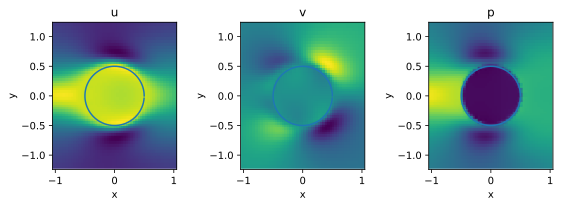

In [14]:
solver.plot_field(λ, xlim=(-1, 1), ylim=(-1, 1))

In [15]:
print("dJ/d(1/Re) = ", (infoϵ['cylinder_fx'][-1]-info['cylinder_fx'][-1])/ϵ, Jq@qu_steady_state, Jq@qu_forward, -λ@Ru)

dJ/d(1/Re) =  2.4046366453589485 2.40463655966361 2.4046368163030474 2.404636816303018
